In [50]:
import os
import re
import glob
import math
import numpy as np
import pandas as pd
import json
import collections
import matplotlib.pyplot as plt
from collections import Counter

from moatless.search.reward import parse_value

results_path = "/share/edc/home/antonis/moatless-tools/evaluations/Moatless - Reported runs (2).xlsx"
run_path = "/share/edc/home/antonis/moatless-tools/evaluations/20240617_moatless_gpt-4o-2024-05-13"

rew_models = ["Qwen/Qwen2-72B-Instruct",
              "gpt-4o", "deepseek/deepseek-chat"]

classification_mapping = {
    "Not Found": ["Failed"],
    "Found but not identified": ["found_in_search"],
    "Incomplete Planning": ["file_identified"],
    "Incorrect Edit": ["edited"],
    "Resolved": ["resolved"]
}

              instance_id            duration           total_cost  \
0  astropy__astropy-12907  12,688974618911743  0,06141500000000001   

   resolved_by           status  transitions  edited  planned  identified  \
0            2  file_identified            8   False    False         NaN   

   expected_identified  ...  EditCode_cost  Finished  Finished_cost  \
0                  NaN  ...        0.01558       1.0            0.0   

                      expected_files                       edited_files  \
0  ['astropy/modeling/separable.py']  ['astropy/modeling/separable.py']   

   error  ClarifyCodeChange  ClarifyCodeChange_cost  Rejected  Rejected_cost  
0    NaN                NaN                     NaN       NaN            NaN  

[1 rows x 42 columns]
['file_identified' 'found_in_search' 'resolved' 'edited' 'identified'
 'Failed']
{'timestamp': '2024-07-22T10:50:34.516772', 'input': {'messages': [{'role': 'system', 'content': 'You are an expert software engineer tasked with ev

/tmp/ipykernel_3985570/1970490185.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')


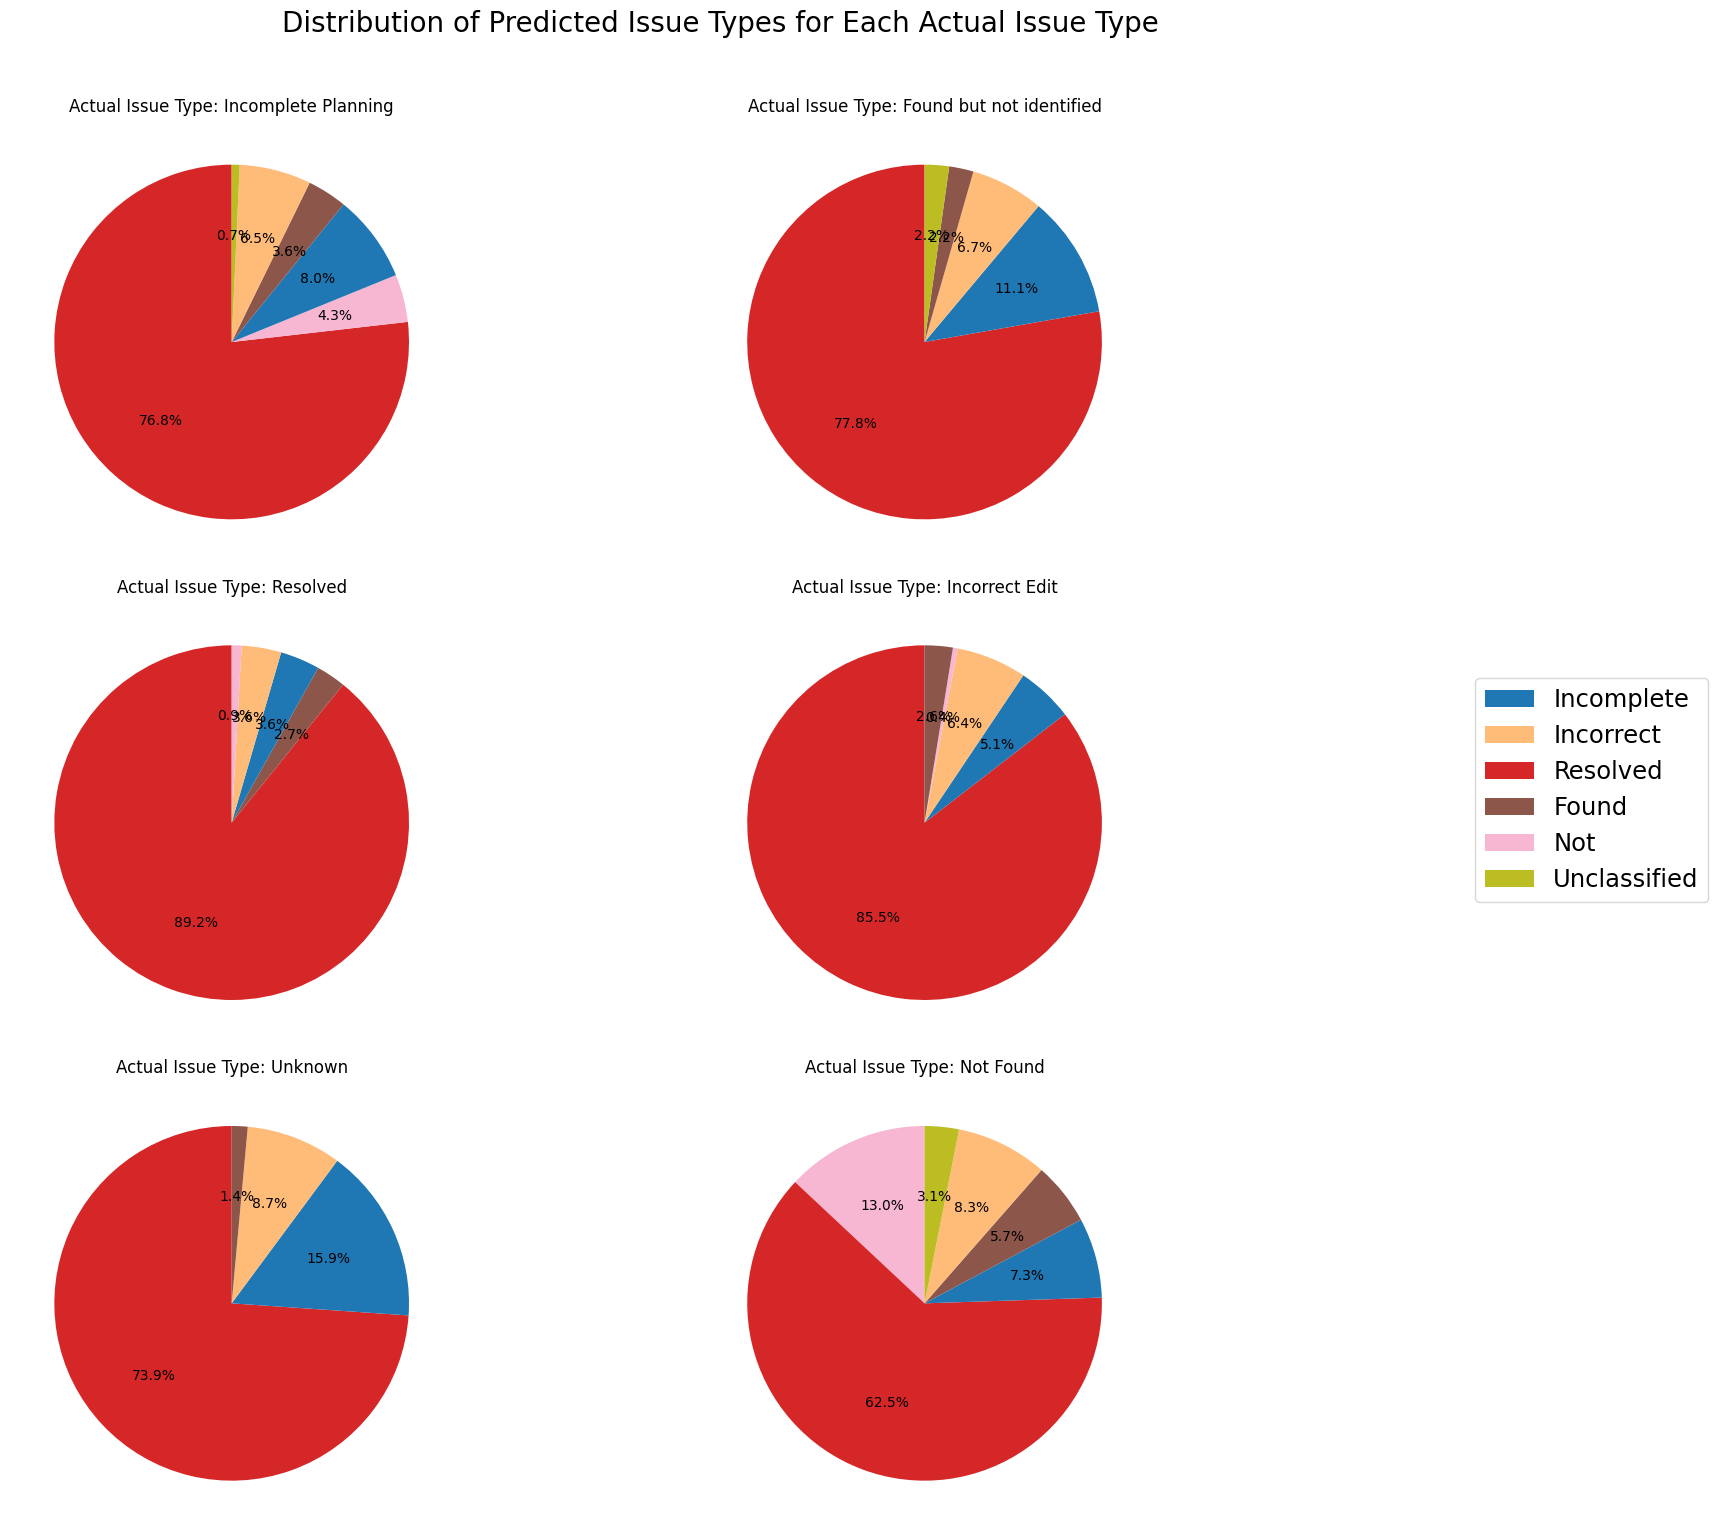

In [51]:
def standardize_classification(classification):
    # Remove quotes and extra whitespace
    classification = classification.strip('"').strip()
    # Remove trailing periods
    classification = classification.rstrip('.')
    # Capitalize the first letter of each word
    classification = ' '.join(word.capitalize() for word in classification.split())
    # Handle special cases
    if classification.lower() == "found but not identified":
        return "Found But Not Identified"
    return classification

def parse_llm_message(response_content):
    """
    Parse the LLM's message to extract relevant information using the parse_value function.

    Args:
    response_content (str): The content of the LLM response.
4
    Returns:
    dict: A dictionary containing the parsed values for each category, with category names as keys.
    """
    categories = ['State', 'Explanation', 'Classification', 'Error', 'Suggestion']
    result = {}

    for category in categories:
        if category == 'Error':
            value = parse_value(response_content, keyword=category, allowed_values=[True, False, 'true', 'false'])
            if value is not None:
                result[f"{category}:"] = value if isinstance(value, bool) else value.lower() == 'true'
        elif category == 'Classification':
            value = parse_value(response_content, keyword=category)
            if value is not None:
                result[f"{category}:"] = standardize_classification(value)
            else:
                result[f"{category}:"] = "Unclassified"  # Default value if Classification is not found
        else:
            value = parse_value(response_content, keyword=category)
            if value is not None:
                result[f"{category}:"] = value

    print(f"Parsed message: {result}")  # Debug print
    return result

excel_data = pd.ExcelFile(results_path)
sheet_names = excel_data.sheet_names

# Load the data from the first sheet
df = pd.read_excel(results_path, sheet_name=sheet_names[-1])

df['status'] = df['status'].fillna('Failed')

# Display the first few rows of the dataframe to understand its structure
print(df.head(1))

print(df['status'].unique())

model_eval_tree_dir = os.path.join(run_path, "tree_eval", rew_models[-2])
model_eval_tree_pth = glob.glob(model_eval_tree_dir + "**/**.json")[0]
model_eval_tree = json.load(open(model_eval_tree_pth))
model_eval_tree

print(model_eval_tree)

llm_message = model_eval_tree['output']['completion_response']['choices'][0]['message']['content']
parsed_message = parse_llm_message(llm_message)
print(parsed_message)


def load_tree_eval_data(run_path, rew_models):
    """
    Load and parse the tree_eval data for each model.

    Args:
    run_path (str): The path to the run directory containing evaluation results.
    rew_models (list): A list of model names.

    Returns:
    dict: A dictionary where keys are model names and values are parsed tree_eval data.
    """
    tree_eval_data = collections.defaultdict(dict)

    for model in rew_models:
        model_eval_tree_dir = os.path.join(run_path, "tree_eval", model)
        model_eval_tree_pth = glob.glob(model_eval_tree_dir + "**/**.json")
        print(f"Found {len(model_eval_tree_pth)} tree eval files for {model}")
        
        for issue in model_eval_tree_pth:
            issue_name = os.path.basename(issue).replace(".json", "")
            model_eval_tree = json.load(open(issue))
            llm_message = model_eval_tree['output']['completion_response']['choices'][0]['message']['content']
            parsed_message = parse_llm_message(llm_message)
            tree_eval_data[model][issue_name] = parsed_message
        
    return tree_eval_data

tree_eval_data = load_tree_eval_data(run_path, rew_models)

def compare_and_plot_issues(df, tree_eval_data, classification_mapping):
    inverted_mapping = {v: k for k, vs in classification_mapping.items() for v in vs}
    
    def map_status(status):
        return inverted_mapping.get(status, "Unknown")
    
    df['mapped_status'] = df['status'].apply(map_status)
    issue_types = df['mapped_status'].unique()
    
    plot_data = {issue_type: {} for issue_type in issue_types}
    
    for model, issues in tree_eval_data.items():
        for issue_name, parsed_message in issues.items():
            actual_type = df.loc[df['instance_id'] == issue_name, 'mapped_status'].iloc[0]
            predicted_type = parsed_message['Classification:']
            
            print(f"Issue: {issue_name}, Actual: {actual_type}, Predicted: {predicted_type}")
            
            if actual_type not in plot_data:
                plot_data[actual_type] = {}
            
            if predicted_type not in plot_data[actual_type]:
                plot_data[actual_type][predicted_type] = 0
            
            plot_data[actual_type][predicted_type] += 1
    
    print("Plot data:")
    for actual_type, predictions in plot_data.items():
        print(f"{actual_type}: {predictions}")
    
    # Get all unique predicted types
    all_predicted_types = set()
    for predictions in plot_data.values():
        all_predicted_types.update(predictions.keys())
    
    # Create a color map
    color_map = plt.cm.get_cmap('tab20')
    colors = {pred_type: color_map(i/len(all_predicted_types)) for i, pred_type in enumerate(all_predicted_types)}
    
    # Plot pie charts
    num_issues = len(issue_types)
    fig, axes = plt.subplots(nrows=(num_issues+1)//2, ncols=2, figsize=(20, 5*((num_issues+1)//2)))
    fig.suptitle("Distribution of Predicted Issue Types for Each Actual Issue Type", 
                 fontsize=20, y=1.02)
    
    for i, (issue_type, predictions) in enumerate(plot_data.items()):
        ax = axes[i//2, i%2]
        labels = list(predictions.keys())
        sizes = list(predictions.values())
        
        ax.pie(sizes, colors=[colors[label] for label in labels], autopct='%1.1f%%', startangle=90)
        ax.set_title(f"Actual Issue Type: {issue_type}")
    
    # Remove any unused subplots
    for i in range(len(plot_data), num_issues):
        fig.delaxes(axes[i//2, i%2])
    
    # Create a legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[label], edgecolor='none') for label in all_predicted_types]
    fig.legend(legend_elements, all_predicted_types, loc='center right', 
               bbox_to_anchor=(1., 0.5), fontsize=17.5)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust this value to make room for the legend
    plt.show()

chosen_models = ["gpt-4o"]
tree_eval_data_chosen = {model: tree_eval_data[model] for model in chosen_models}
# Use the function
compare_and_plot_issues(df, tree_eval_data, classification_mapping)

In [52]:
for model in tree_eval_data.keys():
    print(f"Model: {model}")
    data = tree_eval_data[model]
    compare_and_plot_issues(df, data, classification_mapping)

Model: Qwen/Qwen2-72B-Instruct


IndexError: single positional indexer is out-of-bounds